In [7]:
import pandas as pd
import os
from random import choices
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm
from src.utils import download_table, get_wandb_summaries
from src.data.utils import load_json, download_wandb_table
import wandb
from pprint import pprint
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
import collections
import glob 

import matplotlib.patches as mpatches
from src.data.hierarchical_bootstrapping import hierarchical_bootstrapping
sns.color_palette

colors = sns.color_palette().as_hex()
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [8]:
os.environ["WANDB_SILENT"]="true"

In [9]:
api = wandb.Api()

def search_experiments(model="CNNToTransformerClassifier", task="PredictFluPos", notes="hourly temporal split", tags="pretrained", _n_runs=5):
    """
    returns experiments ids that match a given a model name, task, and notes. Should return one entry per run (i.e. 5)
    """
    
    filters={"summary_metrics.model": model, "summary_metrics.task": task, "notes": notes}
    
    if tags is not None:
        if isinstance(tags, dict) and "not" in tags:
            tags = {"$not": tags["not"]}
        filters["tags"] = tags
    
    query = api.runs(
            path="bdata/ICML-2023-Flu-Dataset",
            filters=filters,
            order="+summary_metrics.pl_seed"
    )

    return query

In [10]:
def get_prediction_tables(run_ids, entities=["mikeamerrill","safranchik"], projects=["ICML-2023-Flu-Dataset", "mobs"], no_mobs=False):
    if no_mobs:
        projects = ["ICML-2023-Flu-Dataset"]
    tables = []
    for run_id in run_ids:
        for entity in entities:
            for project in projects:
                # TODO: pull runs from the bdata/Homekit project 
                try:
                    tables.append(download_wandb_table(run_id.id, table_name="test_predictions", entity=entity, project=project))
                except:
                    continue
    return tables

In [5]:
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
            

In [18]:
fig = plt.gcf()

fig.set_size_inches(30, 20)

METRICS = [roc_auc_score, average_precision_score]
METRICS_NAMES = ["AUROC", "PR-AUC"]

# format: model name, notes, label, color
MODELS = [
            ("CNNToTransformerClassifier", "temporal split", {"not": "pretrained"}, {"label": "CNN-Transformer", "color": colors[0], "marker":'s'}, 0),
            ("CNNToTransformerClassifier", "user split", {"not": "pretrained"}, {"label": "CNN-Transformer", "color": colors[0], "marker":'s'}, 0),
    
          
            ("CNNClassifier", "temporal split", None, {"label": "CNN", "color": colors[1], "marker": "s"}, 1),
            ("CNNClassifier", "user split", None, {"label": "CNN", "color": colors[1], "marker": "s"}, 1),
            ("CNNClassifier", "hourly temporal split", None, {"label": "CNN (hour)", "color": colors[2], "marker": "o"}, 2),
            ("CNNClassifier", "hourly user split", None, {"label": "CNN (hour)", "color": colors[2], "marker": "o"}, 2),
          
            ("TransformerClassifier", "hourly temporal split", None, {"label": "Transformer (hour)", "color": colors[3], "marker": "o"}, 3),
            ("TransformerClassifier", "hourly user split", None, {"label": "Transformer (hour)", "color": colors[3], "marker": "o"}, 3),
    
            ("ResNet", "hourly temporal split", None, {"label": "ResNet (hour)", "color": colors[6], "marker": "o"}, 4),
            ("ResNet", "hourly user split", None, {"label": "ResNet (hour)", "color": colors[6], "marker": "o"}, 4),  
            ("ResNet", "temporal split", None, {"label": "ResNet", "color": colors[6], "marker": "o"}, 4),
            ("ResNet", "user split", None, {"label": "ResNet", "color": colors[6], "marker": "o"}, 4),        
            
            ("XGBoostClassifier", "hourly temporal split", None, {"label": "XGBoost (hour)", "color": colors[5], "marker": 'o'}, 5),
            ("XGBoostClassifier", "hourly user split", None, {"label": "XGBoost (hour)", "color": colors[5], "marker": 'o'}, 5),
    
            ("XGBoostClassifier", "daily temporal split", None, {"label": "XGBoost (day)", "color": colors[5], "marker": 'd'},6),
            ("XGBoostClassifier", "daily user split", None, {"label": "XGBoost (day)", "color": colors[5], "marker": 'd'},6),

            ("InceptionTime", "user split", None, {"label": "InceptionTime", "color": colors[6], "marker": "o"}, 7),
            ("InceptionTime", "temporal split", None, {"label": "InceptionTime", "color": colors[6], "marker": "o"}, 7)
        ]            

TASKS = ["HomekitPredictFluPos", "HomekitPredictSevereFever", "HomekitPredictCough", "HomekitPredictFatigue",  "HomekitPredictFluSymptoms"]
TASK_NAMES = ["Flu Positivity",  "Severe Fever", "Severe Cough", "Severe Fatigue",  "Flu Symptoms"]
TAKS_NAME_MAP=dict(zip(TASKS, TASK_NAMES))

NUM_BOOTSTRAPS=10

assert len(TASKS) == len(TASK_NAMES)

splits = ["user", "temporal"]


<Figure size 3000x2000 with 0 Axes>

In [ ]:

# num_models = max(d[-1] for d in MODELS)

# width = 1/(num_models+2)



metric_results = []
metric_results_with_tables = []

""" fills out the nested data dictionary """
for t, task in enumerate(TASKS):
    for k, (model, note, tags, kwargs, order) in enumerate(MODELS):
        
        model_name = kwargs["label"]
        s = "temporal" if "temporal" in note else "user"
        
        run_ids = search_experiments(model, task, note, tags)
        tables = get_prediction_tables(run_ids, no_mobs=(model=="CNNToTransformerClassifier"))
        
        if not isinstance(tables, list):
            continue
            
        if len(tables) != 5:
            print("{}-{} with note \"{}\" and tags \"{}\" has length {}".format(model, task, note, tags, len(tables)))

            continue

        assert len(tables) == 5
                    
        # 40 model bootstraps lets us discard the bottom and top outliers to obtain a 95% CI
        bootstraps = hierarchical_bootstrapping(tables, num_bootstraps=NUM_BOOTSTRAPS, metrics=METRICS)
            
        for m, metric in enumerate(METRICS):

            bootstraps_list = bootstraps[metric.__name__]
            metric_mean = np.mean(bootstraps_list)
            metric_err = np.abs(np.percentile(bootstraps_list, (0.975, 0.025)) - metric_mean)
            metric_results.append({"model_name": model_name, "task": task,  "metric": metric.__name__, 
                                   "mean": metric_mean, "err": metric_err, "split":s})
            metric_results_with_tables.append({"model_name": model_name, "task": task,  "metric": metric.__name__,
                                                  "mean": metric_mean, "err": metric_err, "split":s, "tables": tables})
            # x = (order+1) * width
            # plt.subplot(2, 2 * len(tasks) + 1, to_
            # subplot_ix(m, s, t))
            # plt.errorbar(x=x, y=metric_mean,yerr=metric_err[:, None], markersize=10, capsize=10, **kwargs)
    
            
# fig.tight_layout()


# handles, labels = [], []

# for t, task_name in enumerate(TASK_NAMES):
#     for note in ["temporal", "user"]:
#         for l, metric_name in enumerate(METRICS_NAMES):
#             s = 0 if "temporal" in note else 1

#             plt.subplot(2, 2 * len(tasks) + 1, to_subplot_ix(m, s, t))
#             plt.xlim(-0.05, 1.05)
            
# #             ax = axs[l, split * len(tasks) + j]
    
#             plt.title("{} ({})".format(metric_name, note))
#             plt.xticks(ticks=[0.5], labels=[task_name])

#     #         for ax_split in axis_splits:
#     #             ax[split, l].axvline(ax_split, color="gray")

#             handle, label =  plt.gca().get_legend_handles_labels()

#             handles.extend(handle)
#             labels.extend(label)


# for handle in handles:
#     handle.has_yerr = False
# plot_dict = collections.OrderedDict(zip(labels, handles))

# # fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncols=10)
# fig.legend(plot_dict.values(), plot_dict.keys(),  loc="lower center", bbox_to_anchor=(0.5, -0.05), ncols=10)

# fig_name = "error_bar.pdf"
# plt.tight_layout()

# fig.savefig(fig_name, bbox_inches='tight', format="pdf")

In [19]:
def precision_at_k(y_true, y_pred, k=10):
    if isinstance(k,float):
        k = int(k*len(y_true))
    y_pred = y_pred.argsort()[-k:][::-1]
    return np.mean(y_true[y_pred])


p_at_ks = []
task_ks = []
ks = [0.0005,0.001,0.005,0.01,0.1]

for result in metric_results_with_tables:
    tables = result["tables"]
    metric = result["metric"]
    task = result["task"]
    split = result["split"]
    
    if not metric == "roc_auc_score": # Only do this once per task per split per model
        continue

    for k in ks:

        task_ks.append({"task":task, "k":k, "n": int(k * len(tables[0]["label"]))})
        mean = np.mean([precision_at_k(tables[i]["label"], tables[i]["pred"],k=k) for i in range(5)])
        p_at_ks.append({"model_name": result["model_name"], "task": task,  "metric": f"p_at_{k}", "split":split, "mean": mean, "k" : k})
     
        
p_at_ks = pd.DataFrame(p_at_ks)
p_at_ks["task"] = p_at_ks["task"].map(TAKS_NAME_MAP)

In [20]:
task_ks_df = pd.DataFrame(task_ks)[["k","n"]].drop_duplicates(subset=["k"])
task_ks_df.sort_values(by=["n", "k"]).reset_index(drop=True)

,k,n
0,0.0005,53
1,0.0010,107
2,0.0050,539
3,0.0100,1079
4,0.1000,10790


In [24]:
np.log(0.1)

-2.3025850929940455

02/08/2023 12:34:04 - WARNING - matplotlib.font_manager -   findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
02/08/2023 12:34:04 - WARNING - matplotlib.font_manager -   findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
02/08/2023 12:34:04 - WARNING - matplotlib.font_manager -   findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
02/08/2023 12:34:04 - WARNING - matplotlib.font_manager -   findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
02/08/2023 12:34:04 - WARNING - matplotlib.font_manager -   findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
02/08/2023 12:34:04 - WARNING - matplotlib.font_manager -   findfont: Generic family 'serif' not found because none of the following families were fou

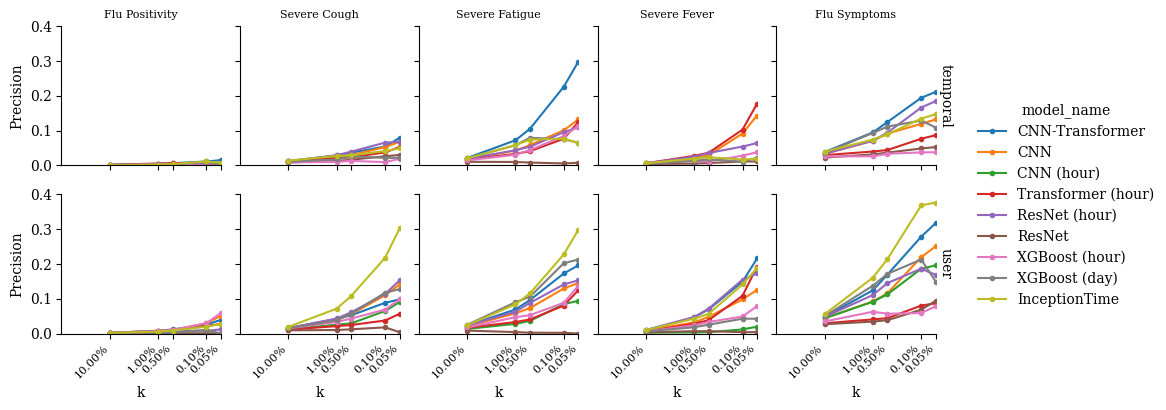

In [23]:
with plt.style.context('./src/visualization/stylesheets/paper.mplstyle'):   
    # Initialize a grid of plots with an Axes for each walk
    # fig = plt.figure(figsize=(20, 10))
    p_at_ks["log_k"] = np.log(p_at_ks["k"])
    grid = sns.FacetGrid(p_at_ks, col="task", hue="model_name", row="split", 
                        height=2, xlim=(log(0.1)), ylim=(0, 0.40), margin_titles=True,
                        legend_out=True)

    # Draw a horizontal line to show the starting point
    # grid.refline(y=0, linestyle=":")
    # Draw a line plot to show the trajectory of each random walk
    grid.map(plt.plot, "log_k", "mean", marker=".")

    grid.set_titles(col_template="{col_name}", row_template="{row_name}")
    grid.set_axis_labels("k", "Precision")

    # # Adjust the tick positions and labels

    x_ticks = [np.log(k) for k in ks]
    x_labels = ["{0:.2%}".format(i) for i in ks]
    grid.set(xticks=x_ticks, xticklabels=x_labels)
    # grid.set(xscale="log")
    ## Rorate the x labels and make them smaller:
    for ax in grid.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_fontsize(8)
            label.set_horizontalalignment('right')
        ax.title.set_fontsize(8)

    ##Make subplot titles smaller
    grid.add_legend()
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # Adjust the arrangement of the plots
    # grid.fig.tight_layout(w_pad=1)
